# TELCO CUSTOMER CHURN

## Business understanding

**context**

Telco atau dalam terjemahaannya berarti perusahaan telepon, pada era yang serba cepat ini memiliki tingkat persaingan yang tinggi. masing pasing provider atau penyedia jasa jaringan mencoba berbagai macam cara untuk menghasilkan strategi yang tepat sasaran dan efektif. salah satu permasalahan yang dihadapi adalah mengenai customer churn atau pelanggan yang berhenti berlangganan dan beralih ke perusahaan kompetitor. dengan mengetahui kemungkinan customer churn, telco company dapat melakukan treatment khusus agar perilaku churn dapat dihindari.

untuk menghadapi kebutuhan yang cepat, seorang Data Scientist diminta untuk membuat model prediksi yang tepat untuk menentukan seorang pelanggan akan churn (beralih) atau tidak.

dalam prosesnya, diminta output berupa nilai 1 untuk customer churn dan 0 untuk tidak churn



**Problem Statement**

menurut [sumber](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/) , mencari customer baru memiliki biaya hingga 5 kali lebih besar dibandingkan dengan mempertahankan customer yang sudah ada. selanjutnya dengan meningkatkan nilai customer loyal sebanyak 5%, keuntungan dapat meningkat hingga 25-95%. Lebih spesifik pada [sumber berikut](https://www.revechat.com/blog/customer-acquisition-cost/) industri telco memerlukan $315 untuk mengakuisisi customer. 

Sehingga dalam mempertahankan pelanggan, sebuah perusahaan telco perlu memperlakukan customer yang ingin churn atau berpindah secara khusus. seperti memberikan potongan harga pada paket data tertentu, memberikan paket langgangan menarik, memberikan prioritas pelayanan lainnya dan upaya lainnya yang dapat meningkatkan loyalitas pelanggan. Namun untuk pemberikan perlakuan harus dilakukan secara selektif, perlakuan khusus harus dimaksimalkan untuk diberikan ke pelanggan yang memang akan berpindah sehingga tepat sasaran. 



**Approach**

model yang dapat digunakan adalah model klasifikasi untuk membantu perusahaan telco menentukan pelanggan yang akan churn atau tidak. dengan target:
    0 : tidak berhenti berlangganan
    1 : berhenti berlangganana
dan untuk menentukan nilai scoring, dilakukan analisis berikut
    Type 1 error : False Positive (pelanggan tidak churn tetapi diprediksi churn) Konsekuensi: insentif menjadi salah sasaran
    Type 2 error : False Negative (pelanggan churn tetapi diprediksi tidak akan churn) Konsekuensi: kehilangan pelanggan
Type 1 dan Type 2 error memiliki kesamaan kepentingan karena kesalahan berdsarkan fasle positive dan false negative akan memberikan kerugian pada peruasahaan. namun karena kebutuhan bisnis untuk mempertahankan customer memiliki kerugian lebih sedikit (dengan memberikan treatment), daripada kehilangan customer sama sekali. maka diterapkan nilai f2_score. sehingga tujuan utama pembuatan model yang mengutamakan mengurangi customer churn, namun tetap meminimalisir pemberian treatment kepada customer yang tidak churn.(nilai recall 2 kali lebih penting dari precision)


In [150]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn import pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, make_scorer, fbeta_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# **Dataset**

In [151]:
data = pd.read_csv('data_telco_customer_churn.csv')
df=pd.DataFrame(data)

Pada data_telco_customer_churn, terdapat features yang memiliki keterangan sebagai berikut
-	Dependents: Whether the customer has dependents or not.
-	Tenure: Number of months the customer has stayed with the company.
-	OnlineSecurity: Whether the customer has online security or not.
-	OnlineBackup: Whether the customer has online backup or not.
-	InternetService: Whether the client is subscribed to Internet service.
-	DeviceProtection: Whether the client has device protection or not.
-	TechSupport: Whether the client has tech support or not 
-	Contract: Type of contract according to duration.
-	PaperlessBilling: Bills issued in paperless form.
-	MonthlyCharges: Amount of charge for service on monthly bases.
-	Churn: Whether the customer churns or not.


# **Data Exploration**

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


jumlah data yang diperoleh sebanyak 4930 atau terdapat 4930 jumlah customer

In [153]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [154]:
display(df.describe(),df.describe(include='object'))

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


In [155]:
cat_columns = ['Dependents','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract','PaperlessBilling']

listitem = []
for col in cat_columns:
    listitem.append([col, df[col].nunique(), df[col].unique()])
cat_Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listitem)
cat_Desc

,Column Name,Number of Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,OnlineSecurity,3,"[No, Yes, No internet service]"
2,OnlineBackup,3,"[No, Yes, No internet service]"
3,InternetService,3,"[DSL, Fiber optic, No]"
4,DeviceProtection,3,"[Yes, No internet service, No]"
5,TechSupport,3,"[Yes, No, No internet service]"
6,Contract,3,"[Month-to-month, Two year, One year]"
7,PaperlessBilling,2,"[Yes, No]"


sehingga diketahui bahwa data sebagian besar merupakan kategorikal ( Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, Tech Support, Contract, PaperlessBilling dan Churn) sedangkan terdapat data numerikal (Tenure dan MonthlyCharges)

In [156]:
df.isnull().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

tidak terdapat data kosong atau missing value pada data yang diperoleh

In [157]:
df.duplicated().sum()

77

In [158]:
df.loc[df.duplicated()]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
624,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
701,No,41,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.65,No
786,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.65,Yes
951,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.15,Yes
1266,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
...,...,...,...,...,...,...,...,...,...,...,...
4759,No,4,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.05,No
4786,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
4788,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,70.10,Yes
4866,No,1,No,No,DSL,No,No,Month-to-month,Yes,55.00,Yes


data tidak memiliki detail unik seperti customer_id sehingga tidak bisa diidentifikasi apakah data duplikat ini sama atau tidak. bisa saja dalam 2 atau lebih customer memesan paket yang sama sehingga memiliki contract dan charge sama, dengan karakteristik (dependents, tenure, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, PaperlessBilling)

sehingga data duplikat ini tidak dihapus

No     73.31
Yes    26.69
Name: Churn, dtype: float64

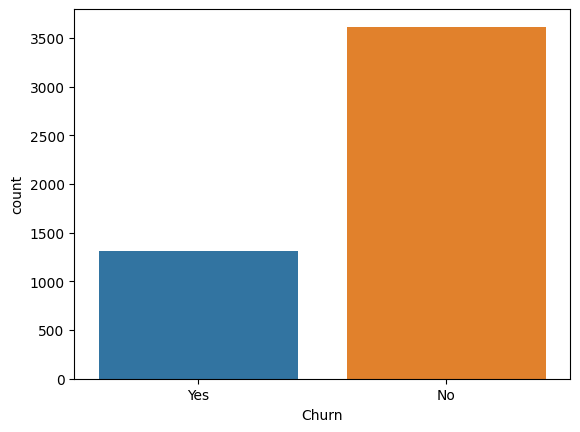

In [159]:
sns.countplot(x=df['Churn'])
df['Churn'].value_counts(normalize=True).mul(100).round(2)

In [160]:
df['Churn'].value_counts()

No     3614
Yes    1316
Name: Churn, dtype: int64

Terdapat imbalance data pada nilai feature Churn yaitu untuk data customer churn sebanyak 1316 dan yang tidak churn 3614

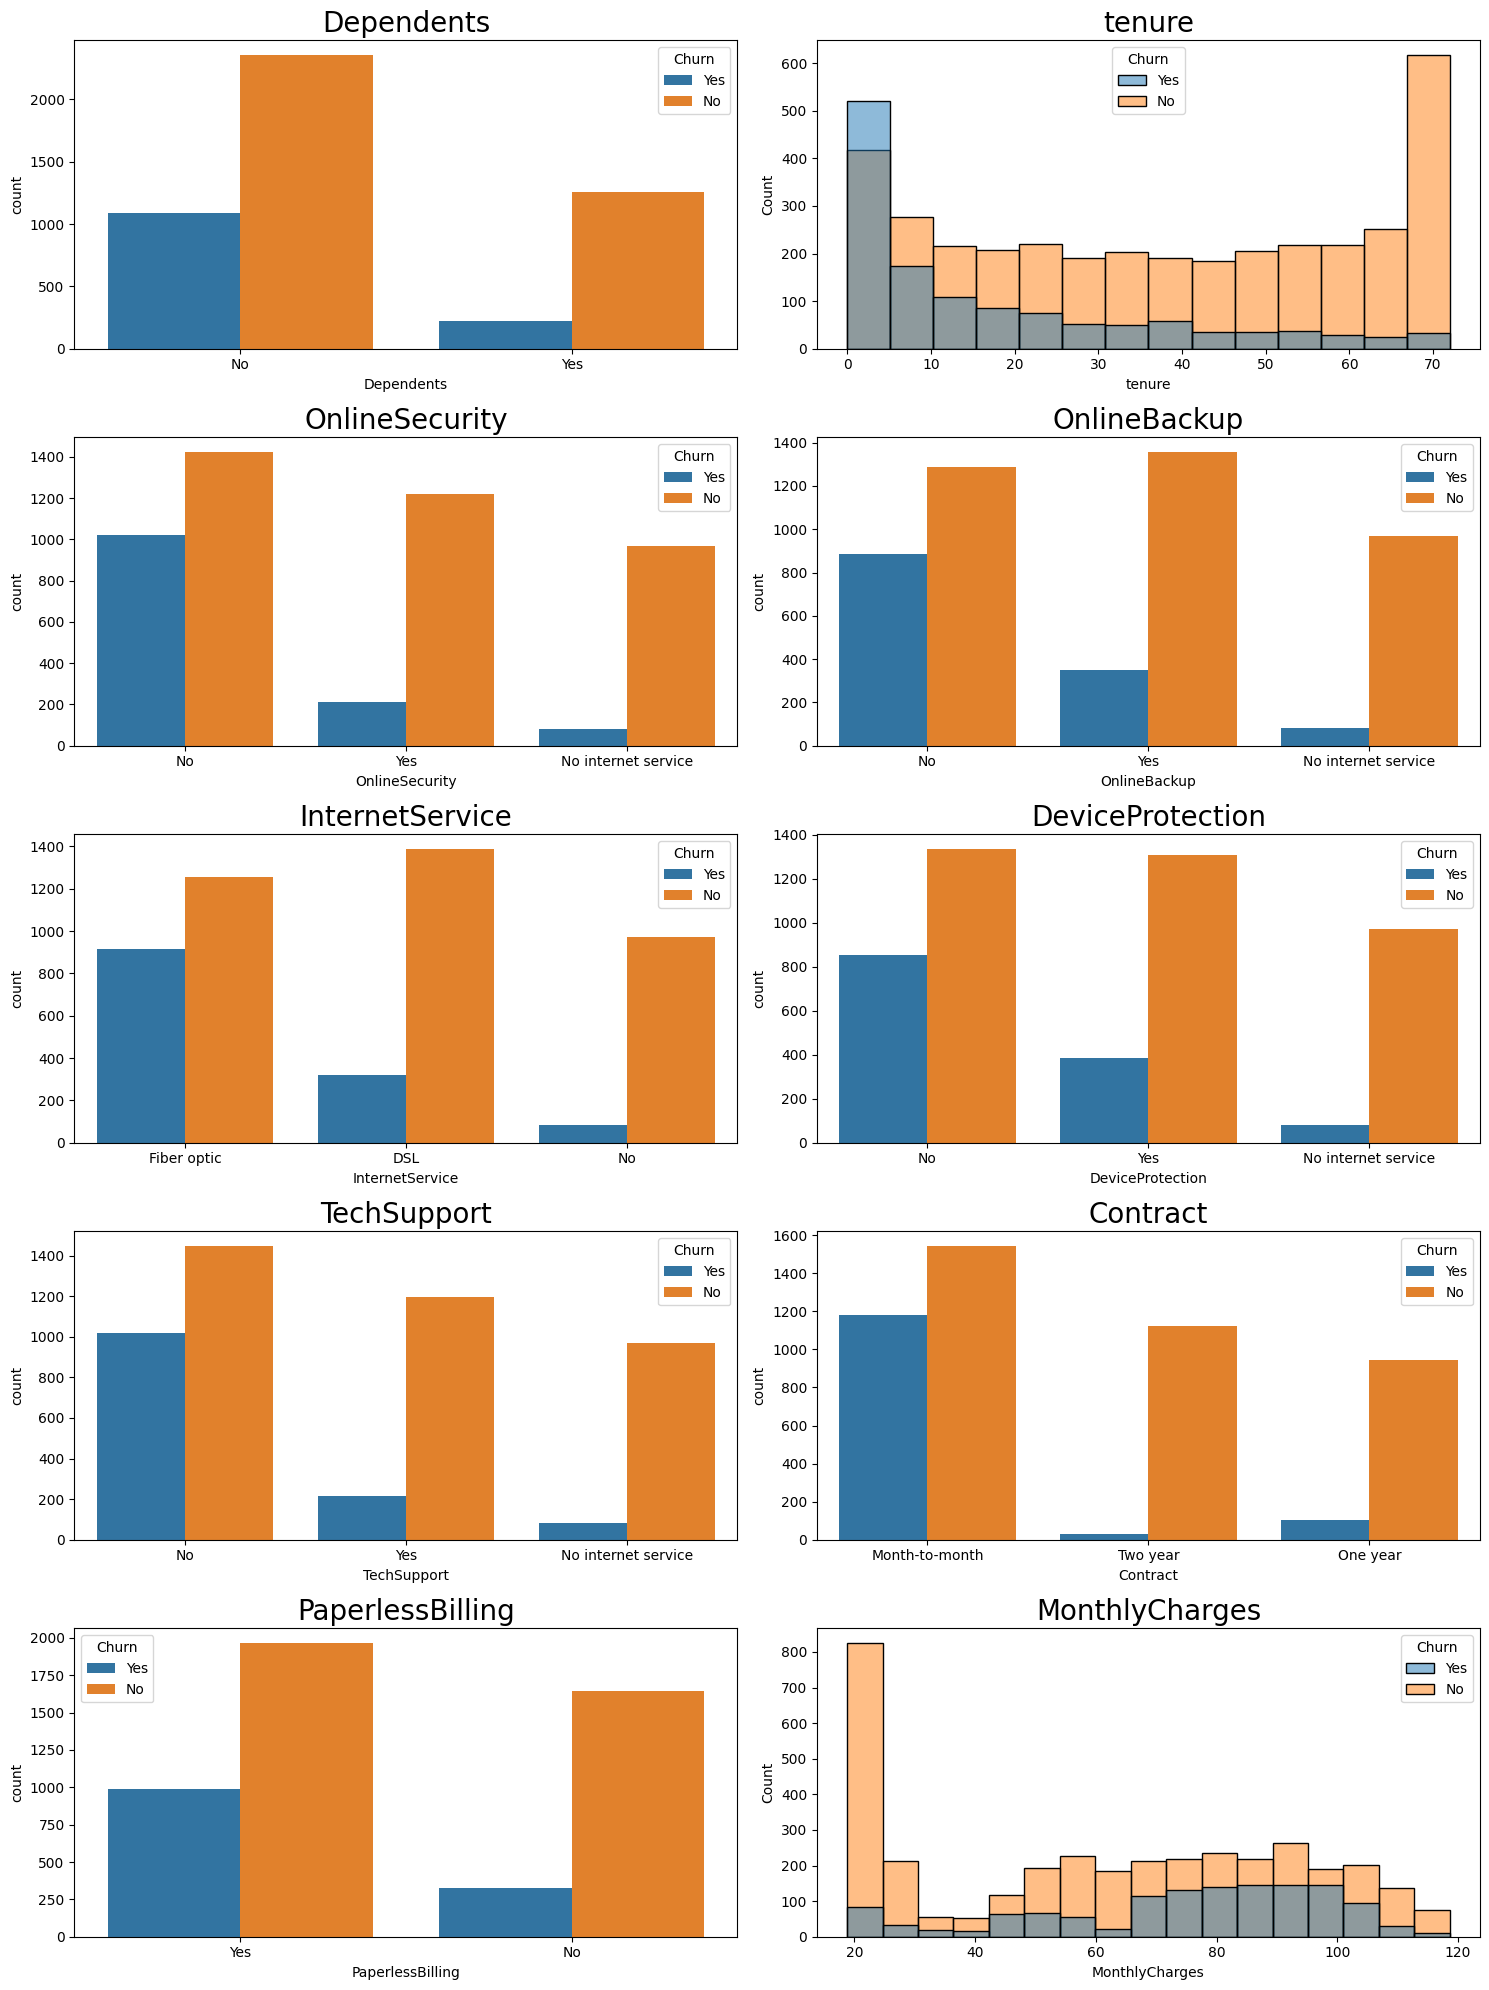

In [161]:
cat_columns = ['Dependents','tenure','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract','PaperlessBilling','MonthlyCharges']
plt.figure(figsize=(15,20))

for i, column in enumerate(cat_columns):
    if column=='tenure' or column=='MonthlyCharges':
        plot = sns.histplot(x=df[column], ax=plt.subplot(5,2,i+1),hue=df['Churn'])
    else:
        plot = sns.countplot(x=df[column], ax=plt.subplot(5,2,i+1), order=df[column].value_counts().index,hue=df['Churn'])
    plot.set_title(column,fontdict={'fontsize':20})
plt.tight_layout()
plt.show()

dari data terlihat bahwa
1. mayoritas pelanggan tidak memiliki tanggungan (dependents)
1. pelanggan yang memilih untuk churn umumnya ketika baru berlangganan pada 5 bulan awal (tenure)
1. kebanyakan pelanggan tidak memiliki online security, online backup, device protection dan Tech Support
1. kebanyakan pelanggan memlih kontrak month to month
1. mayoritas pelanggan menggunakan paperles billing

In [162]:
# cek outlier di boxplot untuk tenure sama monthly charge

<Axes: xlabel='tenure'>

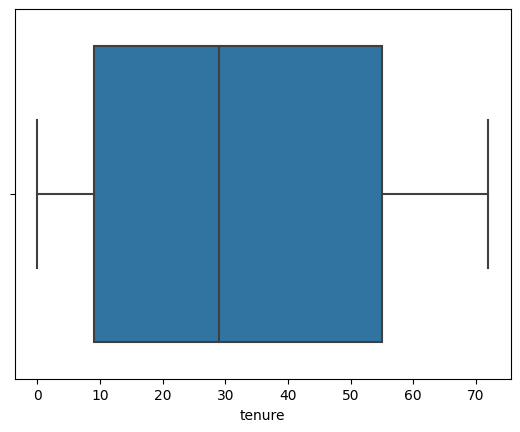

In [163]:
sns.boxplot(x=df['tenure'])

<Axes: xlabel='MonthlyCharges'>

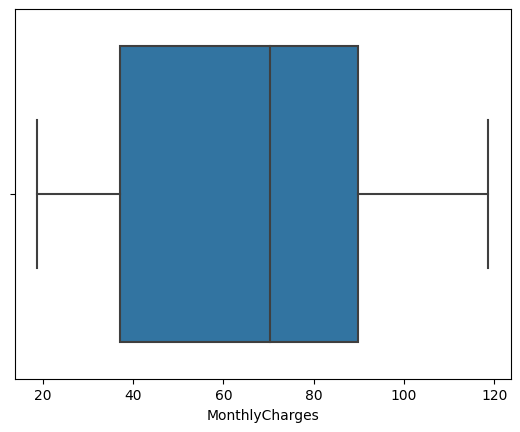

In [164]:
sns.boxplot(x=df['MonthlyCharges'])

tidak terdapat nilai outlier pada data numerikal monthly charges dan tenure

# **Data Preprocessing**

## Perubahan nilai Churn

label masih berbentuk string, sehingga akan dirubah menjadi numerik (1 adalah Yes, 0 adalah No)

In [165]:
df['Churn'] = np.where(df['Churn']=='Yes',1,0)

## Scaling

pada model, akan dilakukan perbandingan model pada saat menggunakan scaling dan tidak menggunakan scaling, karena pada feature numerik tidak terdapat outlier, maka digunakan MinMaxScaler untuk melakukan scaling pada data

harapannya dengan menggunakan scaling, diperoleh hasil yang lebih baik dan skalatis (feature dengan variabel besar akan mendominasi fearture dnegan variabel kecil)

In [166]:
scaler = MinMaxScaler()

## Encoding

In [167]:
cat_Desc

,Column Name,Number of Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,OnlineSecurity,3,"[No, Yes, No internet service]"
2,OnlineBackup,3,"[No, Yes, No internet service]"
3,InternetService,3,"[DSL, Fiber optic, No]"
4,DeviceProtection,3,"[Yes, No internet service, No]"
5,TechSupport,3,"[Yes, No, No internet service]"
6,Contract,3,"[Month-to-month, Two year, One year]"
7,PaperlessBilling,2,"[Yes, No]"


berdasarkan tabel diatas, encoding dilakukan menurut keterangan berikut : 
1. Dependents dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya 2
1. OnlineSecurity dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang sedikit
1. OnlineBackup dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya sedikit
1. InternetService dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya sedikit
1. DeviceProtection dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya sedikit
1. TechSupport dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya sedikit
1. Contract dengan ordinal encoding karena nilainya bertingkat mulai dari month-to month, One Year dan Two Year
1. OnlineBackup dengan menggunakan One Hot Encoder karena fitur ini tidak memiliki urutan ordinal dan jumlah uniqe data yang hanya sedikit

In [215]:
ct = ColumnTransformer([
    ("onehot", OneHotEncoder(drop='first'), ['Dependents','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','PaperlessBilling']),
    ("ordinal", OrdinalEncoder(),['Contract'])
], remainder='passthrough')

ctscal = ColumnTransformer([
    ("onehot", OneHotEncoder(drop='first'), ['Dependents','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','PaperlessBilling']),
    ("ordinal", OrdinalEncoder(),['Contract']),
    ("Scalling", scaler, ['MonthlyCharges', 'tenure'])
], remainder='passthrough')

## Imblance Data

data yang kita miliki memiliki imbalance data dan termasuk pada [mild imbalance](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) dengan proporsi kelas minoritas sebesar 26.6%. agar distribusi kelas seimbang, kita akan menerapkan metode resampling yaitu Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC), Hal ini dikarenakan :

* agar tidak menghilangkan informasi penting data pada kelas mayoritas, tidak digunakan undersammpling.
* untuk menghindari overfitting karena penduplikasian data yang telah ada sebelumnya sehingga pengklasifikasi terkena informasi yang sama jika menggunakan Random Oversampling. 
* pada data kita terdapat fitur yang numerikal (continuous) and kategorikal (nominal).

In [216]:
df.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'Churn'],
      dtype='object')

In [217]:
resample = SMOTENC(random_state=0, categorical_features=[0, 2, 3, 4, 5, 6, 7, 8])#['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 
                                                                                 # 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']

## Splitting Data

sebelum dilakukan modeling, feature dan label perlu dipisah

In [218]:
label = df['Churn']
features = df.drop(columns='Churn')

selanjutnya dilakukan splitting untuk menghasilkan train dan test data. hal ini dilakukan agar tidak terjadi leakage pada data

In [220]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3,random_state=42, stratify=label)

In [221]:
print(
    label.shape,
    features.shape,
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape)

(4930,) (4930, 10) (3451, 10) (1479, 10) (3451,) (1479,)


In [222]:
y_train.value_counts(normalize=True)

0    0.733121
1    0.266879
Name: Churn, dtype: float64

In [223]:
y_test.value_counts(normalize=True)

0    0.732928
1    0.267072
Name: Churn, dtype: float64

diperoleh nilai yang seimbang antara train dan test data

## SCALING CHECK

untuk mengetahui pengaruh scaling pada data, dilakukan pengecekan nilai score pada model dengan scaling dan tanpa menggunakan scaling sebagai bahan pertimbangan untuk melakukan scaling.

In [224]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
grad = GradientBoostingClassifier(random_state=0)
cat = CatBoostClassifier(verbose=False,random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

models = [logreg,knn,tree,rf,ada,grad,cat,xgb,lgbm]

In [225]:
f2_score = make_scorer(fbeta_score,beta=2)

In [226]:
mean_w_scaling=[]
std_w_scaling=[]
mean_wo_scaling=[]
std_wo_scaling=[]

kf = StratifiedKFold(5) # Metode cross validation

for model in models:
    pipe_wo_scaling = Pipeline([
        ("Preprocesing", ct),
        ("Modeling", model)
    ]) # Pipeline

    model_cv_wo_scaling = cross_val_score(pipe_wo_scaling, X_train, y_train, cv=kf, scoring=f2_score) # Scoring cross validation
    mean_wo_scaling.append(model_cv_wo_scaling.mean())
    std_wo_scaling.append(model_cv_wo_scaling.std()) 

    pipe_w_scaling = Pipeline([
        ("Preprocesing", ctscal),
        ("Modeling", model)
    ]) # Pipeline

    model_cv_w_scaling = cross_val_score(pipe_w_scaling, X_train, y_train, cv=kf, scoring=f2_score) # Scoring cross validation
    mean_w_scaling.append(model_cv_w_scaling.mean())
    std_w_scaling.append(model_cv_w_scaling.std())


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [227]:
data_scaling = pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN', 'Decision Tree','RandomForest','adaBoost','GradienBoost','CatBoost','XGBoost','LightGBM'],
    'mean_f2_with_scaling' : mean_w_scaling,
    'mean_f2c_without_scaling' : mean_wo_scaling,
    'std_f2_with_scaling' : std_w_scaling,
    'std_f2_without_scaling' : std_wo_scaling,
})

In [228]:
data_scaling

,model,mean_f2_with_scaling,mean_f2c_without_scaling,std_f2_with_scaling,std_f2_without_scaling
0,Logistic Regression,0.544663,0.541562,0.038205,0.032731
1,KNN,0.525519,0.524622,0.018163,0.024274
2,Decision Tree,0.498836,0.495815,0.030380,0.026799
3,RandomForest,0.501017,0.505700,0.029593,0.022835
4,adaBoost,0.532020,0.532138,0.019239,0.019165
5,GradienBoost,0.517833,0.517833,0.026615,0.026615
6,CatBoost,0.528615,0.526902,0.040887,0.032997
7,XGBoost,0.513806,0.522648,0.037782,0.038344
8,LightGBM,0.534735,0.529678,0.033395,0.038803


terlihat pada nilai score bahwa dengan menggunakan scaling, nilai rata" score sedikit lebih tinggi. untuk menghindari feature dengan skala besar mendominasi perhitungan model, dilakukan modeling dengan menggunakan scaling

pada nilai scaling ini, terlihat bahwa nilai f2_score terbaik diperoleh model Logistic Regression yaitu 0.54. namun nilai ini masih kurang baik untuk dijadikan model sehingga perlu dipertimbangkan imbalance data.

### Imbalance Data

selanjutnya dilakukan scoring pada model yang menerapkan imbalance data dan tanpa menerapkan imbalance data. sehingga kita dapat menentukan apakah imbalance data perlu untuk dimasukan ke dalam model

In [229]:
mean_w_sampling=[]
std_w_sampling=[]
mean_wo_sampling=[]
std_wo_sampling=[]

kf = StratifiedKFold(5) # Metode cross validation

for model in models:
    
    pipe_wo_sampling = pipeline.Pipeline([
        ("Preprocesing", ctscal),
        ("Modeling", model)
    ]) # Pipeline
    
    model_cv_wo_sampling = cross_val_score(pipe_wo_sampling, X_train, y_train, cv=kf, scoring=f2_score) # Scoring cross validation
    mean_wo_sampling.append(model_cv_wo_sampling.mean())
    std_wo_sampling.append(model_cv_wo_sampling.std()) 

    pipe_w_sampling = pipeline.Pipeline([
        ("Preprocesing", ctscal),
        ("sampling",resample),
        ("Modeling", model)
        
    ]) # Pipeline

    model_cv_w_sampling = cross_val_score(pipe_w_sampling, X_train, y_train, cv=kf, scoring=f2_score) # Scoring cross validation
    mean_w_sampling.append(model_cv_w_sampling.mean())
    std_w_sampling.append(model_cv_w_sampling.std())  

In [230]:
data_sampling = pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN', 'Decision Tree','RandomForest','adaBoost','GradienBoost','CatBoost','XGBoost','LightGBM'],
    'mean_f2_with_sampling' : mean_w_sampling,
    'mean_f2_without_sampling' : mean_wo_sampling,
    'std_f2_with_sampling' : std_w_sampling,
    'std_f2_without_sampling' : std_wo_sampling,
})

In [265]:
display (data_sampling)

,model,mean_f2_with_sampling,mean_f2_without_sampling,std_f2_with_sampling,std_f2_without_sampling
0,Logistic Regression,0.701247,0.544663,0.009627,0.038205
1,KNN,0.623386,0.525519,0.021530,0.018163
2,Decision Tree,0.551650,0.498836,0.021218,0.030380
3,RandomForest,0.579478,0.501017,0.038810,0.029593
4,adaBoost,0.707873,0.532020,0.011710,0.019239
5,GradienBoost,0.693529,0.517833,0.022080,0.026615
6,CatBoost,0.653164,0.528615,0.029702,0.040887
7,XGBoost,0.592792,0.513806,0.028383,0.037782
8,LightGBM,0.637081,0.534735,0.029597,0.033395


diperoleh score dengan menggunakan sampling lebih tinggi dengan tanpa sampling. sehingga ctscal dipakai sebagai preprocessing dengan memasukan imbalance data dan scaling.

kenaikan nilai scoring model yang menandakan bahwa sampling berpengaruh besar untuk modeling.

pada default hyperparameter, nilai Logistic Regression dan adaBoost memiliki nilai tinggi. 

## Pipeline terpakai

In [232]:
def train(model):
    return pipeline.Pipeline([
        ("Preprocesing", ctscal),
        ("sampling",resample),
        ("Modeling", model)
    ])

## MODEL BENCHMARKING - DEAFULT HYPERPARAMETER : TRAIN & TEST DATA

model

In [233]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
grad = GradientBoostingClassifier(random_state=0)
cat = CatBoostClassifier(verbose=False,random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

models = [logreg,knn,tree,rf,ada,grad,cat,xgb,lgbm]

parameters

dalam memilih parameter untuk melakukan hyperparameter tunning ke banyak model, perlu ditentukan parameter apa saja dari setiap model yang dirasa signifikan terhadap hasil model. Menurut sebuah [artikel](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/), terdapat beberapa parameter yang lebih signifikan terhadap parameter lainnya. kita akan coba beberapa parameter berikut yang dirasa signifikan terhadap model
1. Logistic Regression yaitu penalty solver dan nilai C
1. KNN yaitu n_neighbors
1. Decision Tree yaitu max_depth
1. Random Forrest yaitu max_features dan n_estimators
1. AdaBoost yaitu learning_rate
1. GradientBoost yaitu learning_rate
1. CatBoost yaitu scale_pos_weight
1. XGBoost yaitu scale_pos_weight
1. LightGBM yaitu scale_pos_weight

nilai parameter yang akan dipilih terdapat pada code berikut

In [234]:
param_logreg = {
    'Modeling__penalty' : ['l1', 'l2', 'elasticnet', None],
    'Modeling__solver' : ['newton-c', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'Modeling__C' : [100, 10, 1.0, 0.1, 0.01]
}

param_knn = {
    'Modeling__n_neighbors' : range(1,22,2),
    'Modeling__weights' : ['uniform','distance'],
    'Modeling__metric' : ['euclidean', 'manhattan', 'minkowski']
}

param_tree = {
    'Modeling__max_depth' : range(1,10,1)
}

param_rf = {
    'Modeling__max_features' :["sqrt", "log2", None],
    'Modeling__n_estimators' : range(10,1000,100)
}

param_ada = {'Modeling__learning_rate' : [0.001, 0.01, 0.1]}
param_grad = {'Modeling__learning_rate' : [0.001, 0.01, 0.1]}
param_cat = {'Modeling__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}
param_xgb = {'Modeling__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}
param_lgbm = {'Modeling__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}

params = [param_logreg,param_knn,param_tree,param_rf,param_ada,param_grad,param_cat,param_xgb,param_lgbm]

In [235]:
best_param = []
best_score = []
best_model = []

for model,param in zip(models,params):
    rs = RandomizedSearchCV(
        estimator= train(model),
        param_distributions=param,
        verbose=1,
        cv=kf,
        scoring=f2_score
        )
    rs.fit(X_train,y_train)
    best_param.append(rs.best_params_)
    best_score.append(rs.best_score_)
    best_model.append(rs.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters

25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\X1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\X1\AppData\Local\Programs\Python\Python310\lib\site-pack

Fitting 5 folds for each of 10 candidates, totalling 50 fits


The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [236]:
hasil = pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','adaBoost','GradienBoost','CatBoost','XGBoost','LightGBM'],
             'best param': best_param,
             'best f2 score': best_score
             })
pd.set_option("display.max_colwidth",None)
hasil

,model,best param,best f2 score
0,Logistic Regression,"{'Modeling__solver': 'saga', 'Modeling__penalty': 'l1', 'Modeling__C': 0.01}",0.730094
1,KNN,"{'Modeling__weights': 'uniform', 'Modeling__n_neighbors': 21, 'Modeling__metric': 'manhattan'}",0.705711
2,Decision Tree,{'Modeling__max_depth': 1},0.729438
3,Random Forest,"{'Modeling__n_estimators': 810, 'Modeling__max_features': None}",0.591305
4,adaBoost,{'Modeling__learning_rate': 0.001},0.729438
5,GradienBoost,{'Modeling__learning_rate': 0.001},0.710918
6,CatBoost,{'Modeling__scale_pos_weight': 10},0.726925
7,XGBoost,{'Modeling__scale_pos_weight': 10},0.699660
8,LightGBM,{'Modeling__scale_pos_weight': 20},0.727170


diperoleh parameter terbaik menurut hyperparameter tunning. terlihat pada train set nilai tetinggi ada pada logistic regression. untuk memvalidasi nilai ini, dilakukan pada test data

Tunning for test data

In [237]:
score_test = []
score_train = []

for i in zip(best_model):
    i[0].fit(X_train,y_train)
    y_pred_test = i[0].predict(X_test)
    y_pred_train = i[0].predict(X_train)
    score_test.append(fbeta_score(y_test,y_pred_test,beta=2))
    score_train.append(fbeta_score(y_train,y_pred_train,beta=2))

In [238]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','adaBoost','GradienBoost','CatBoost','XGBoost','LightGBM'],
             'f2 score (train set)': score_train,
             'f2 score (validation set)': best_score,
             'f2 score (test set)': score_test})

,model,f2 score (train set),f2 score (validation set),f2 score (test set)
0,Logistic Regression,0.733346,0.730094,0.755442
1,KNN,0.743745,0.705711,0.703336
2,Decision Tree,0.729614,0.729438,0.756373
3,Random Forest,0.986756,0.591305,0.609398
4,adaBoost,0.729614,0.729438,0.756373
5,GradienBoost,0.711322,0.710918,0.715601
6,CatBoost,0.793788,0.726925,0.752515
7,XGBoost,0.876142,0.699660,0.722006
8,LightGBM,0.796713,0.727170,0.739847


untuk interpretable ML diperoleh nilai paling baik yaitu pada Decision Tree dan untuk explainable ML diperoleh nilai paling baik pada Light GBM. nilai baik ini dilandasi oleh nilai f2 score yang cukup tinggi pada training dan test set dan nilai f2 score juga cukup stabil pada training dan test set.

## HYPERPARAMETER TUNNING FOR ITERPRETABLE ML : DECISION TREE

In [239]:
param_tree = {
    'Modeling__max_depth' : range(1,20,1),
    'Modeling__min_samples_split' : range(2,200,2),
    'Modeling__min_samples_leaf' : range(1,50,1)
}

pipe =  pipeline.Pipeline([
    ("Preprocesing", ctscal),
    ("sampling",resample),
    ("Modeling", DecisionTreeClassifier(random_state=0))
])

random_search_tree = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_tree,
    cv=kf,
    scoring=f2_score,
    n_jobs=-1,
    n_iter=100,
    random_state=0
)

random_search_tree.fit(X_train,y_train)
random_search_tree_best_score=random_search_tree.best_score_
print(random_search_tree_best_score)
print(random_search_tree.best_params_)

0.729438224346857
{'Modeling__min_samples_split': 180, 'Modeling__min_samples_leaf': 19, 'Modeling__max_depth': 1}


In [241]:
best_model_tree = random_search_tree.best_estimator_
best_model_tree.fit(X_train, y_train)

Pipeline(steps=[('Preprocesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaperlessBilling']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Contract']),
                                                 ('Scalling', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'tenure'])])),
                ('sampling',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8],
                         random_state=0)),
                ('Modeling',
                 DecisionTreeClassifier(max_depth=1, min_samples_leaf=19,
                                        min_samples_split=180,
                                        random_state=0))])

In [242]:
tree_benchmark =  pipeline.Pipeline([
    ("Preprocesing", ctscal),
    ("sampling",resample),
    ("Modeling", DecisionTreeClassifier(max_depth =3,random_state=0))
])
tree_benchmark.fit(X_train,y_train)

Pipeline(steps=[('Preprocesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaperlessBilling']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Contract']),
                                                 ('Scalling', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'tenure'])])),
                ('sampling',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8],
                         random_state=0)),
                ('Modeling',
                 DecisionTreeClassifier(max_depth=3, random_state=0))])

In [243]:
y_pred_default = tree_benchmark.predict(X_test)
y_pred_tuned = best_model_tree.predict(X_test)

f2_default_tree = fbeta_score(y_test, y_pred_default, beta=2)
f2_tuned_tree = fbeta_score(y_test, y_pred_tuned, beta=2)

print('f2 Score Default Decision Tree : ', f2_default_tree)
print('f2 Score Tuned Decision Tree : ', f2_tuned_tree)

f2 Score Default Decision Tree :  0.7156005522319373
f2 Score Tuned Decision Tree :  0.7563727538654408


setelah dilakukan Hyperparameter Tunning lebih lanjut pada Decision Tree, nilai score menjadi lebih baik

## Hyperparameter Tunning for Explainable ML : LightGBM

In [244]:
param_lgbm = {
    'Modeling__scale_pos_weight' : [2, 3, 5, 10, 20, 30],
    'Modeling__learning_rate' : [0.001, 0.01, 0.1, 1],
    'Modeling__max_depth' : range(2,10,1)
}

# RandomizedSearch CV

pipe = pipeline.Pipeline([
    ('prep', ctscal),
    ('sampling', resample),
    ('Modeling', LGBMClassifier(random_state=0))
])

random_search_lgbm = RandomizedSearchCV(
    estimator = pipe,
    param_distributions=param_lgbm,
    cv=kf,
    scoring=f2_score,
    n_jobs=-1,
    n_iter = 50,
    random_state = 0
)

random_search_lgbm.fit(X_train, y_train)
random_search_lgbm_best_score=random_search_lgbm.best_score_
print(random_search_lgbm.best_score_)
print(random_search_lgbm.best_params_)

0.7428664891471592
{'Modeling__scale_pos_weight': 3, 'Modeling__max_depth': 2, 'Modeling__learning_rate': 0.1}


In [245]:
pd.DataFrame(random_search_lgbm.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Modeling__scale_pos_weight,param_Modeling__max_depth,param_Modeling__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.741361,0.008247,0.018594,0.002927,3,2,0.1,"{'Modeling__scale_pos_weight': 3, 'Modeling__max_depth': 2, 'Modeling__learning_rate': 0.1}",0.748477,0.744774,0.752829,0.734144,0.734109,0.742866,0.007578,1
32,0.916848,0.054189,0.026197,0.011171,2,2,0.1,"{'Modeling__scale_pos_weight': 2, 'Modeling__max_depth': 2, 'Modeling__learning_rate': 0.1}",0.745654,0.737557,0.739051,0.738225,0.739008,0.739899,0.002930,2
31,1.096237,0.068411,0.028830,0.014496,3,3,0.01,"{'Modeling__scale_pos_weight': 3, 'Modeling__max_depth': 3, 'Modeling__learning_rate': 0.01}",0.752174,0.735422,0.723297,0.736041,0.736704,0.736728,0.009178,3
49,0.997715,0.062152,0.025101,0.008669,3,4,0.01,"{'Modeling__scale_pos_weight': 3, 'Modeling__max_depth': 4, 'Modeling__learning_rate': 0.01}",0.746269,0.735294,0.723514,0.730241,0.745536,0.736171,0.008784,4
6,0.933054,0.080577,0.028523,0.010327,2,5,0.001,"{'Modeling__scale_pos_weight': 2, 'Modeling__max_depth': 5, 'Modeling__learning_rate': 0.001}",0.741583,0.733645,0.723385,0.720109,0.733519,0.730448,0.007752,5


In [246]:
best_model_lgbm = random_search_lgbm.best_estimator_
best_model_lgbm.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaperlessBilling']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Contract']),
                                                 ('Scalling', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'tenure'])])),
                ('sampling',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8],
                         random_state=0)),
                ('Modeling',
                 LGBMClassifier(max_depth=2, random_state=0,
                                scale_pos_weight=3))])

In [247]:
lgbm_benchmark = pipeline.Pipeline([
    ('prep', ctscal),
    ('sampling', resample),
    ('Modeling', LGBMClassifier(scale_pos_weight= 20,random_state=0))
])

lgbm_benchmark.fit(X_train, y_train)
# y_pred_lgbm_benchmark = lgbm_benchmark.predict(X_test)
# fbeta_score(y_test, y_pred_lgbm_benchmark, beta=2)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaperlessBilling']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Contract']),
                                                 ('Scalling', MinMaxScaler(),
                                                  ['MonthlyCharges',
                                                   'tenure'])])),
                ('sampling',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8],
                         random_state=0)),
                ('Modeling',
                 LGBMClassifier(random_state=0, scale_pos_weight=20))])

In [248]:
y_pred_default = lgbm_benchmark.predict(X_test)
y_pred_tuned = best_model_lgbm.predict(X_test)

f2_default_lgbm = fbeta_score(y_test, y_pred_default, beta=2)
f2_tuned_lgbm = fbeta_score(y_test, y_pred_tuned, beta=2)

print('f2 Score Default LGBM : ', f2_default_lgbm)
print('f2 Score Tuned LGBM : ', f2_tuned_lgbm)

f2 Score Default LGBM :  0.7398472054684359
f2 Score Tuned LGBM :  0.7532840722495894


terlihat bahwa setelah dilakukan tunning, score LightGBM menjadi lebih baik

## KOMPARASI : DECISION TREE DAN LIGHTGBM

In [249]:
# membuat tabulasi f2 score
df_score = pd.DataFrame({
    'Decision Tree' : [best_score[2], random_search_tree_best_score, f2_default_tree, f2_tuned_tree],
    'LightGBM' : [best_score[6], random_search_lgbm_best_score, f2_default_lgbm, f2_tuned_lgbm],
})

col_1 = ['Train Set', 'Train Set', 'Test Set', 'Test Set',]
col_2 = ['Benchmark Model', 'Tuning Model', 'Benchmark Model', 'Tuning Model']

hier_index = list(zip(col_1, col_2))

multi = pd.MultiIndex.from_tuples(hier_index)

df_score.index = multi
df_score

Decision Tree  LightGBM
Train Set Benchmark Model       0.729438  0.726925
          Tuning Model          0.729438  0.742866
Test Set  Benchmark Model       0.715601  0.739847
          Tuning Model          0.756373  0.753284

LightGBM memiliki nilai yang konsisten dan cenderung tinggi pada tunning Model pada train dan test set. sehingga dipilih LightGBM sebagai model yang paling baik untuk menentukan customer perusahaan Telco yang akan churn

## FINAL MODEL - LIGHTGBM

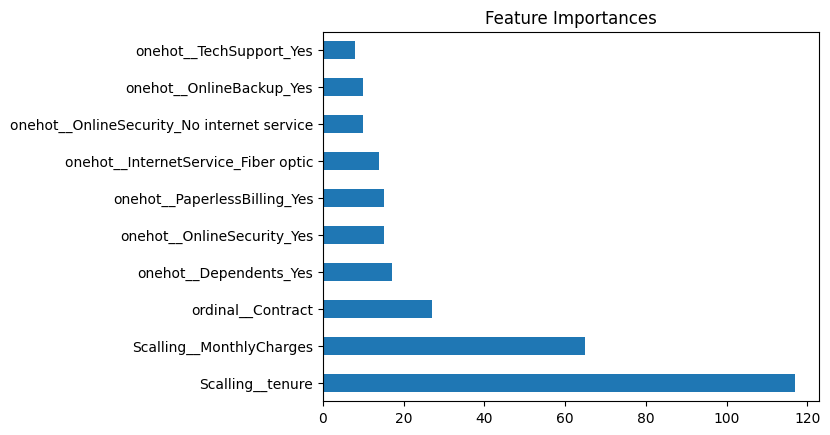

In [253]:
coef1 = pd.Series(best_model_lgbm['Modeling'].feature_importances_, ctscal.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

In [254]:
trans_resample = pipeline.Pipeline([
    ('prep', ctscal),
    ('sampling', resample)
])

X_train_over, y_train_over = trans_resample.fit_resample(X_train, y_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


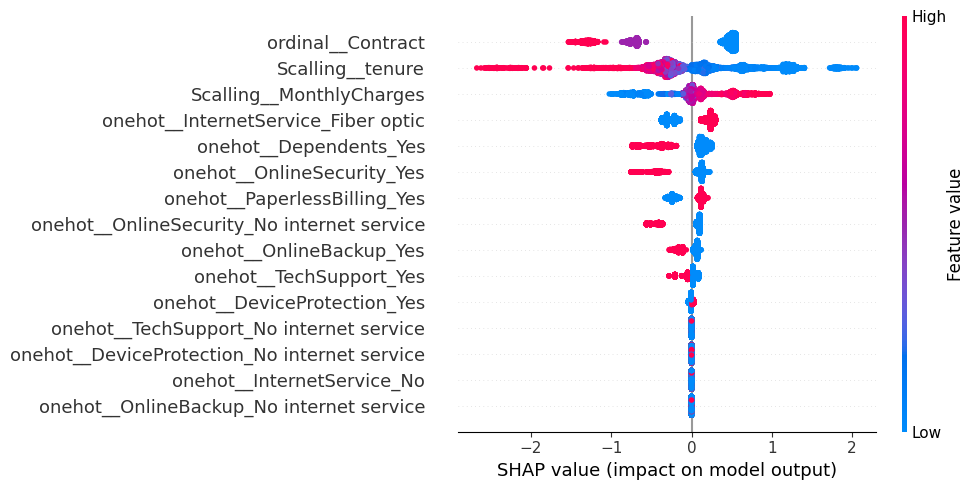

In [256]:
import shap

explain = shap.TreeExplainer (best_model_lgbm['Modeling'])
shap_values = explain.shap_values(X_train_over)

shap.summary_plot(shap_values[1],X_train_over, feature_names = ctscal.get_feature_names_out(),plot_size=(10,5))

pada plot nilai signifikansi feature, diperoleh nilai tenure yang menjadi faktor utama, dilanjutkan oleh Monthly Charges lalu contract.

untuk mengetahui nilai dari encoding yang sudah dilakukan, selanjutnya dilakukan reverse encoding untuk melihat maksud dari angka tersebut

Interpretasi
* pelanggan dengan Contract yang lebih rendah, yaitu dengan kontrak month-to-month akan cenderung memiliki kemungkinan untuk churn dibandingkan dengan kontrak One Year atau Two Year 
* pelanggan dengan tenure yang lebih pendek memiliki kecenderungan untuk churn dibandingkan dengan tenure yang lebih lama
* pelanggan dengan monthly charge lebih tinggi akan memiliki kecenderungan untuk churn dibandingkan dengan monthly charge lebih rendah
* pelanggan dengan intenet service fiber optik akan memiliki kecenderungan untuk churn dibandingkan dengan intenet service DSL atau No
* pelanggan dengan internet dengan dependents atau tanggungan memiliki kecenderungan untuk churn

In [266]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn,pred_proba
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,1,0.343574
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,0,0.090147
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,1,0.775747
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,0,0.967758
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,0,0.288319


In [257]:
shap.initjs()

In [284]:
pred_proba = best_model_lgbm.predict_proba(df)
pred_proba = pred_proba[:,0]
temp = df
temp['pred_proba'] = pred_proba
best_candidate = temp.sort_values('pred_proba',ascending=False)
best_candidate = best_candidate.loc[best_candidate['Churn']==1]
best_candidate = best_candidate.head(5)
best_candidate

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn,pred_proba
304,Yes,55,Yes,Yes,DSL,No,Yes,Two year,No,57.55,1,0.928975
433,Yes,66,Yes,Yes,DSL,Yes,Yes,Two year,No,79.40,1,0.920657
2540,No,59,No internet service,No internet service,No,No internet service,No internet service,Two year,No,19.35,1,0.916783
1100,No,72,Yes,Yes,Fiber optic,Yes,Yes,One year,Yes,117.80,1,0.912214
1281,Yes,72,No,Yes,Fiber optic,Yes,No,Two year,Yes,103.40,1,0.910523


In [285]:
best_candidate_features = best_candidate.iloc[:, :-2]
best_candidate_features

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges
304,Yes,55,Yes,Yes,DSL,No,Yes,Two year,No,57.55
433,Yes,66,Yes,Yes,DSL,Yes,Yes,Two year,No,79.40
2540,No,59,No internet service,No internet service,No,No internet service,No internet service,Two year,No,19.35
1100,No,72,Yes,Yes,Fiber optic,Yes,Yes,One year,Yes,117.80
1281,Yes,72,No,Yes,Fiber optic,Yes,No,Two year,Yes,103.40


In [286]:
def shap_plot(j,model,S, columns):
    values = model.predict(S, pred_contrib=True)
    y_pred = model.predict(S)[j]
    shap_values = values[:,:-1]
    base_values = values[:,-1]
    
    p = shap.force_plot(base_values[j], shap_values[j], S[j], columns)
    print(f"The prediction must predict this passenger is: {('Not Potential' if y_pred == 1 else 'Potential')} from y_test")
    return p

In [287]:
# Kandidat 1
model = best_model_lgbm.named_steps['Modeling']
feature = best_model_lgbm.named_steps['prep'].transform(best_candidate_features)
columns = best_model_lgbm.named_steps['prep'].get_feature_names_out()

shap_plot(0,model,feature, columns)

The prediction must predict this passenger is: Potential from y_test


In [288]:
# Kandidat 2
model = best_model_lgbm.named_steps['Modeling']
feature = best_model_lgbm.named_steps['prep'].transform(best_candidate_features)
columns = best_model_lgbm.named_steps['prep'].get_feature_names_out()

shap_plot(1,model,feature, columns)

The prediction must predict this passenger is: Potential from y_test


In [289]:
# Kandidat 3
model = best_model_lgbm.named_steps['Modeling']
feature = best_model_lgbm.named_steps['prep'].transform(best_candidate_features)
columns = best_model_lgbm.named_steps['prep'].get_feature_names_out()

shap_plot(2,model,feature, columns)

The prediction must predict this passenger is: Potential from y_test


## Conclusion and Recomendation

#### Conclusion

* metric utama untuk scoring yang digunakan adalah f2_score karena recall dua kali lebih penting dibandingkan precision
* berdasarkan hyperparameter tunning dan komparasi antara interpretable dan explainable ML, model terbaik yaitu LightGBM memiliki parameter
    * scale_pos_weight : 3
    * max_depth : 2
    * learning_rate : 0.1
* berdasarkan visualisasi feature importance, fitur yang paling penting adalah tenure yang diikuti dengan MonthlyCharges dan Contract
* interpretasi SHAP : 
    * pelanggan dengan Contract yang lebih rendah, yaitu dengan kontrak month-to-month akan cenderung memiliki kemungkinan untuk churn dibandingkan dengan kontrak One Year atau Two Year 
    * pelanggan dengan tenure yang lebih pendek memiliki kecenderungan untuk churn dibandingkan dengan tenure yang lebih lama
    * pelanggan dengan monthly charge lebih tinggi akan memiliki kecenderungan untuk churn dibandingkan dengan monthly charge lebih rendah
    * pelanggan dengan intenet service fiber optik akan memiliki kecenderungan untuk churn dibandingkan dengan intenet service DSL atau No
    * pelanggan dengan internet dengan dependents atau tanggungan memiliki kecenderungan untuk churn

## Model Limitation

Model yang dihasilkan akan berlaku sesuai dengan batasan data yang ada, yaitu

* tenure antara 0 sampai dengan 72 bulan
* MonthlyCharges antara 18.8 sampai dengan 118.65
* Contract dalam jangka Month-to-month, One year, dan Two Year
* InternetService berupa 'DSL', 'Fiber Optic' dan 'No'
* Dependent, Paperless Billing dengan nilai 'Yes' atau 'No'
* OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport berisi pilihan 'Yes', 'No' atau 'No internet service'.

sehingga selain dengan batasan ini, model menjadi tidak valid

## Recommendation

untuk menghadapi customer churn, dapat dilakukan beberapa langkah atau strategi berikut
* untuk pelanggan beralih contract menjadi jangka panjang, berikan insentif atau bonus lebih pada kontrak 1 tahun dan juga lebih banyak lagi pada 2 tahun yang bersifat jangka panjang
* Customer Loyalty Program, sehingga pelanggan akan tertarik untuk menjadi pelanggan tetap dengan adanya program tersebut. Loyalty program bisa berupa pemberian reward/hadiah sesuai dengan lamanya berlangganan sesuai dengan masa tenure.
* potongan harga ketika monthly charge sudah sampai pada titik tertentu sehingga adanya pembatasan monthly charge
* membuat paket tambahan layanan fiber optik dengan diskon
* paket khusus keluarga untuk menarik perhatian pihak yang memiliki tanggunan atau dependants dengan bonus yang signifikan sehingga membalikkan faktor dependant yang menjadi faktor untuk churn.

## Saving Model

In [290]:
import pickle
pickle.dump(best_model_lgbm,open('best_model_lightgbm.sav','wb'))